# Company Name Similarity Analysis

For my project, I decided to group companies by the top 100 based on their yearly market capitalization (mcap) sums. From there, I took a list of unique company names from that dataset and calculated a score for each name by comparing them to a list of 1000 popular names and generating a similarity score based on how similar the names were. 

For example, if a company was named "ABBOTT LABORATORIES," it would end up matching the most with the name "ABBOTT." The company had a similarity score of 0.333 based on the number of letters that matched the name vs. the total length of the name: 6/18 => 0.333. This tries to distinguish just how much of the company name is composed of the popular name itself. For example, if a name was "Don" and the company was "MacDonald" vs. a company named "Don," it's worth crediting the company named "Don" with a higher score than "MacDonald" since it's literally the same name.

Some additional notes:
- Since the list of popular names is relatively recent, only years 2000+ were considered.
- To avoid unintentionally and coincidental name matching, names that are 2 characters or less were ignored. Many names and words contain "LE" or "LI," and it might not be accurate to include those.

Finally, an additional variable was created which also weighted the similarity of the name based on how popular the name was. For example, a score using the name ABBOTT shouldn't score as high as a company using SMITH. So, both the similarity score and the popularity value of the score are taken into account.

Various testing was done, but the overall conclusion was that the correlation for how similar a name was, weighted or not, didn't account for any significant difference in a company's yearly mcap. Nor did it significantly impact whether the company would rank highly as one of the top 3 performing companies for that year as well. 

The chart below demonstrates that the companies with the highest yearly mcap (anything over ~4.5 billion) had zero similarity to any of the popular names from the list.

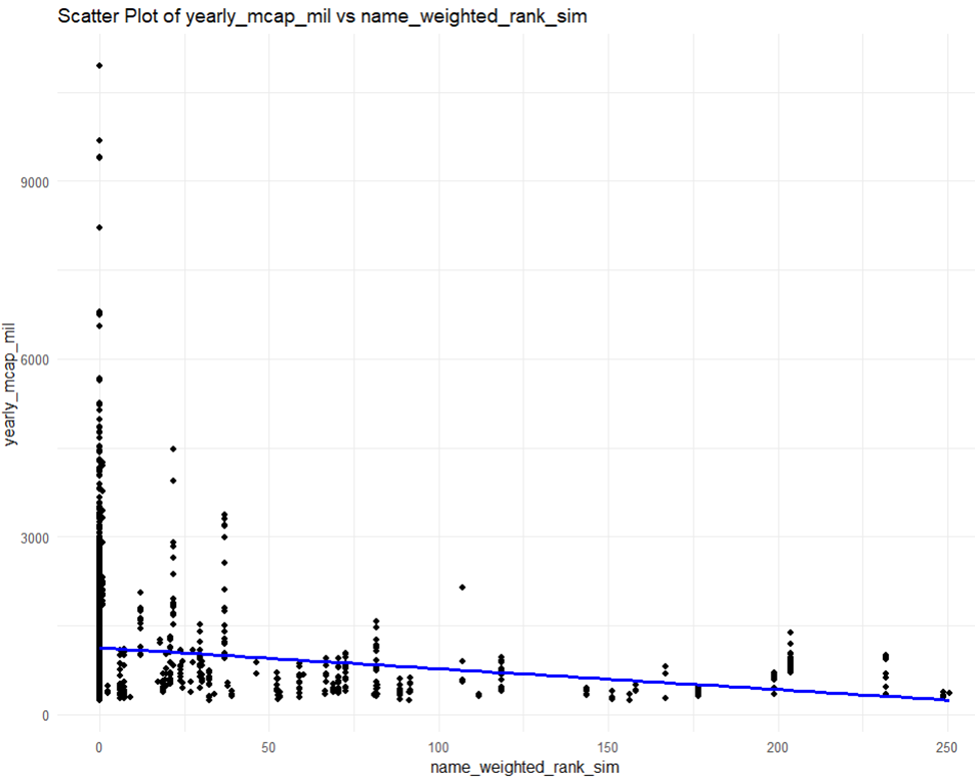

More work could be done with this data to confirm this point, such as using a phonetic comparison, like string distance libraries. Another test worth considering is binning companies that have any sort of similarity vs. companies that don't have a similarity at all and comparing the overall mcap of both groups.

Ultimately, it depends on the question you wish to answer:
- Do you want to know if you'll perform better than companies that don't have a similar name if your company has a similar name to a popular surname?
- Or do you want to know if having a company name that's similar to a popular name will result in a higher mcap than other companies?

These two factors may not be the same, or they may align on some levels. More research and testing would be necessary to determine this.


In [ ]:
## Let's Install Required Packages if not already installed
if (!requireNamespace("dplyr", quietly = TRUE)) {
  install.packages("dplyr")
}
if (!requireNamespace("haven", quietly = TRUE)) {
  install.packages("haven")
}
if (!requireNamespace("stringdist", quietly = TRUE)) {
 install.packages("stringdist")
}
# if (!requireNamespace("phonics", quietly = TRUE)) {
#   install.packages("phonics")
# }
if (!requireNamespace("ggplot2", quietly = TRUE)) {
  install.packages("ggplot2")
}
if (!requireNamespace("stringr", quietly = TRUE)) {
  install.packages("stringr")
}
if (!requireNamespace("purrr", quietly = TRUE)) {
  install.packages("purrr")
}

## Include libraries needed...
library(dplyr)
library(haven)
library(stringdist)
#library(phonics)
library(ggplot2)
library(stringr)
library(purrr)

In [ ]:
# Let's first read in the data file as a data frame
# Expected to be one directory above the module folder of this R file
script_dir <- dirname(sys.frame(1)$ofile)
# NOTE: dev_data_file was used during dev to help speed up loading/processing/testing
# dev_data_file <- file.path(script_dir, "../mret7018_TEMP_DEV_100.sas7bdat")
data_file <- file.path(script_dir, "./data/mret7018.sas7bdat") # extract from `mret7018.sas7bdat.zip`
# View(data_file)

# Let's also read in the Names.csv file
# Expected to be one directory above the module folder of this R file
names_data_file <- file.path(script_dir, "./data/Names.csv")
names_df <- read.csv(names_data_file)
as.data.frame(names_df)

# Let's rename the rank column to avoid mixing up later on
names_df <- names_df %>%
  # mutate(name_weighted_rank = 1/rank) %>% # considered weighting it this way previously
  filter(nchar(name) > 2) %>% # Remove 2 character last names, seems unfair to include them
  mutate(name_weighted_rank = rank,
         name = str_trim(name)) %>%
  select(-rank, -X, -X.1)
# View(names_df)

In [ ]:
##########################################################
# Pre processing, collecting top 100 for each year...
##########################################################
mret <- read_sas(data_file
        # , n_max = 2000 # read in only 2000 rows for testing
)
as.data.frame(mret)

mret <- mret %>% 
  filter(SHRCD %in% c(10,11)) %>% 
  arrange(PERMNO, DATE) 
# head(mret) 

# First let's create an abs(PRC) and mcap variable...
mret <-
  mret %>%
  mutate(year = as.numeric(format(DATE,"%Y")),
         month = as.numeric(format(DATE,"%m")),
         COMNAM = str_trim(COMNAM),
         PRC = abs(PRC),
         mcap = PRC * SHROUT)

In [ ]:
# Let's group by year and calculate a yearly mcap 
# and rank the top 100 companies per year based on yearly_mcap
# Going to focus on more recent years rather than the all the years
# This is due to the names reflecting more recent years than previous years
top_n_mcap_per_year <- mret %>%
  filter(year > 2000) %>%
  group_by(year, PERMNO, COMNAM) %>%
  summarize(yearly_mcap = sum(mcap)) %>%
  group_by(year) %>%
  mutate(rank = rank(desc(yearly_mcap))) %>%
  filter(rank <= 100) %>%
  # filter(COMNAM == "ABBOTT LABORATORIES") %>%
  arrange(year, rank)

View(top_n_mcap_per_year)

In [ ]:
# Let's create a list of unique COMNAM based on the companies from our top n mcap per year
# We need to actually ungroup by year to get a proper distinct of our dataset of interest
# So let's do that, then group by company name
unique_comnam_df <- top_n_mcap_per_year %>%
  ungroup() %>%
  distinct(COMNAM) %>%
  data.frame()

In [ ]:
# Let's create a file so I don't have to read the main file in every time...
# write_sas(top_mcap_per_year, dev_data_file)

# If using a pre-written file, load it here:
# top_n_mcap_per_year <- read_sas(dev_data_file)
# as.data.frame(top_n_mcap_per_year)
# print(top_mcap_per_year$COMNAM)

In [ ]:
# Comparing Similarity Between Names based on pattern matching via grepl
# Extract the vectors of company names and names into seperate vectors...
company_names <- unique_comnam_df$COMNAM
names <- names_df$name

In [ ]:
# The below will define some methods, and execute them on our unique set of company names.
# The point is to determine to what degree a name represented as a regex type pattern matches a company
# Example: "ABBOTT LABRATORIES" company name contains "ABBOTT" so it has a 0.33333 similarity score.
# It matched 6 of the 18 characters in the name, so 6/18 is the similarity score it would have
# Function to calculate similarity for a pair of names
calculate_similarity <- function(company_name, name) {
  # If it matches, it grepl will return 1, if it matched, then multiply it by the nchar of the name matched
  matching_chars <- sum(grepl(name, company_name, ignore.case = TRUE))*nchar(name)
  total_chars <- max(nchar(company_name),0)
  similarity <- matching_chars / total_chars
  return(similarity)
}

# Function to return both the name with the highest similarity and the score for that similarity
# via a list return value
find_best_matching_name <- function(company_name, names) {
  max_similarity <- 0
  best_matching_name <- ""
  
  for (name in names) {
    similarity <- calculate_similarity(company_name, name)
    #print(paste("Comparing:", company_name, "and", name, "| Similarity:", similarity))
    
    if (similarity > max_similarity) {
      max_similarity <- similarity
      best_matching_name <- name
    }
  }
  
  if (max_similarity > 0) {
    #print(paste("Best matching name:", best_matching_name, "| Similarity:", max_similarity))
    return(list(name = best_matching_name, similarity = max_similarity))
  } else {
    #print("No matching name found.")
    return(list(name = "", similarity = 0))  # Default values when no match is found
  }
}

In [ ]:
# Function to update dataframe with best matching name and max similarity
# You can give it a dataframe, a company name column, and the names dataset we want to compare that column to
# It'll then go through and run each row against the find_best_matching_name method
# Since this is df is the unique names one, it'll run it against each name once and then mutate the values onto each row
update_dataframe <- function(df, company_name_col, names) {
  df <- df %>%
    mutate(best_matching_name = map_chr({{company_name_col}}, ~find_best_matching_name(., names)$name),
           max_similarity = map_dbl({{company_name_col}}, ~find_best_matching_name(., names)$similarity))
  return(df)
}


# Update unique_comnam_df with best matching name and max similarity
# This is done by actually executing the update_dataframe method
updated_unique_df <- update_dataframe(unique_comnam_df, COMNAM, names_df$name)

# View the updated dataframe
View(updated_unique_df)

# Merge the unique COMNAM results into the full dataset of top 100 yearly performing MCAP companies...
top_n_mcap_per_year2 <- merge(top_n_mcap_per_year, updated_unique_df, by.x = "COMNAM", by.y = "COMNAM", all.x = TRUE)

View(top_n_mcap_per_year2)
View(names_df)

# Merge the names_df back in to get more detail about the name that was matched the most to a given company (eg: name popularity rank etc)
top_n_mcap_per_year3 <- merge(top_n_mcap_per_year2, names_df, by.x = "best_matching_name", by.y = "name", all.x = TRUE)

In [ ]:
# Now that we know more about the name that was matched for a company, such as it's popularity rank
# Let's create a new column which takes the similarity score and multiplies it by how popular the name is
# This results in a company having a score that's based on both how much of the name is based on a person's surname
# As well as based on how popular that surname actually is also
top_n_mcap_per_year3 <- top_n_mcap_per_year3 %>%
  mutate(name_weighted_rank_sim = name_weighted_rank * max_similarity) %>%
  mutate(name_weighted_rank_sim = coalesce(name_weighted_rank_sim, 0))


# Next, let's try to take the top 100 companies and determine the top 3 ranked for that year.
# If you're one of the top 3, you're considered high mcap for that year compared to the other 97 companies
top_n_mcap_per_year3 <- top_n_mcap_per_year3 %>%
  mutate(high_mcap = ifelse(rank %in% 1:3, 1, 0),
         yearly_mcap_mil = yearly_mcap / 1000000) # yearly mcap in millions $

View(top_n_mcap_per_year3)

In [ ]:
# Now let's perform some correlations.

# First is to determine what correlation if any the name similarity might have upon a company's yearly mcap...
correlation1 <- cor(top_n_mcap_per_year3$yearly_mcap_mil, top_n_mcap_per_year3$name_weighted_rank_sim, use = "complete.obs")
cat("Correlation Coefficient (yearly_mcap):", correlation1, "\n")

# Next is to determine what correlation if any exists based on similarity to determine if it'll be a factor in making
# your company a high mcap one for the year or not
correlation2 <- cor(top_n_mcap_per_year3$high_mcap, top_n_mcap_per_year3$name_weighted_rank_sim, use = "complete.obs")
cat("Correlation Coefficient (high_mcap):", correlation2, "\n")


# Let's create a scatter plot to help demonstrate this as well...
# Scatter plot with trendline
ggplot(top_n_mcap_per_year3, aes(x = name_weighted_rank_sim, y = yearly_mcap_mil)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "blue") +
  labs(title = "Scatter Plot of yearly_mcap_mil vs name_weighted_rank_sim",
       x = "name_weighted_rank_sim",
       y = "yearly_mcap_mil") +
  theme_minimal()

In [ ]:
# Since we're interested in demonstrating the point if a name's simalarity has a significant role in determining 
# if a company will be successful high mcap based company or not, let's create a simple model and try to make some predictions
fit <- lm(high_mcap ~ max_similarity+name_weighted_rank_sim
          , data=top_n_mcap_per_year3)
print(summary(fit)) # show results 

# The results are simply that it doesn't really contribute anything, and that the R Square is pretty low, so it's not even a good model at all based on variables related to the similarity.

**FUTURE TODO:**

Might be interesting to add a NN model which takes into account the name of the company and the similarity to popular names and then try to predict what mcap might be for the year
If the model is able to accurately be trained, then one could take into consideration what amount of a name would need to be similar to have a potential impact.
It would also be potentially worthwhile to look into calculating phonetic similarity scores using phonetic library
And possibly string distance library also and incorporating that as well.